## IMPORTATION DES LIBRAIRIES ET VERIFICATION DE DEMARRAGE

Parametrage des variables d'environnement

Importation des packages Python et démarrage d'une session Spark en local

In [169]:
from pyspark import SparkContext, SparkConf
conf = SparkConf().setAppName('TP3').setMaster('local')
sc = SparkContext.getOrCreate(conf = conf)

import pyspark.sql.functions as psf
import pandas as pd

Verification de la version de Spark et du nom de l'application

In [42]:
print(spark.version)
print(sc.appName)

3.0.1
PySparkShell


## IMPORT DU JEU DE DONNEES

## Indiquer le dossier et le fichier cible

In [43]:
dossier = "C:/Tran_Nam_Mai/Github Profile/Apache-Spark-Big-Data-Processing/Data/"
fichier = dossier + "Infections.txt"

## Importer les jeux de donnees 
Prediction de maladies sur un jeu de donnees de maladies aux Etats-Unis

Importation depuis le fichier texte 'Infections.txt'

In [60]:
data_spark = spark.read.text(fichier)

## PREPARATION/NETTOYAGE DU JEU DE DONNEES

## Preparer les donnees

Afficher la taille du jeu de donnees initial (nombre de lignes et colonnes)

In [69]:
print(data_spark.count())
print(len(data_spark.columns))

222625
1


Afficher les 3 premières lignes du jeu de donnees (entieres, non abregees)

In [80]:
data_spark.head(3)

[Row(value='ProviderID\tHospitalName\tAddress\tCity\tState\tZIPCode\tCountyName\tPhoneNumber\tMeasureName\tMeasureID\tComparedToNationalScore\tFootnote'),
 Row(value='10001\tSOUTHEAST ALABAMA MEDICAL CENTER\t1108 ROSS CLARK CIRCLE\tDOTHAN\tAL\t36301\tHOUSTON\t3347938701\tCLABSI: Lower Confidence Limit\tHAI_1_CI_LOWER\tNo Different than National Benchmark\t0.313'),
 Row(value='10001\tSOUTHEAST ALABAMA MEDICAL CENTER\t1108 ROSS CLARK CIRCLE\tDOTHAN\tAL\t36301\tHOUSTON\t3347938701\tCLABSI: Upper Confidence Limit\tHAI_1_CI_UPPER\tNo Different than National Benchmark\t3.348')]

In [81]:
data_spark.columns

['value']

Creer un nouveau jeu de donnees en extrayant de la chaine de caracteres les variables 'Hopital' (variable d'indice 1), 'Ville' (indice 3), 'Etat' (indice 4), 'NomMesure' (indice 8), 'IDMesure' (indice 9), 'Comparaison' (indice 10), 'Score' (indice 11)

In [225]:
split_col = psf.split(data_spark['value'], '\t')
data = data_spark.withColumn('Hopital', split_col.getItem(1))
data = data.withColumn('Ville', split_col.getItem(3))
data = data.withColumn('Etat', split_col.getItem(4))
data = data.withColumn('NomMesure', split_col.getItem(8))
data = data.withColumn('IDMesure', split_col.getItem(9))
data = data.withColumn('Comparaison', split_col.getItem(10))
data = data.withColumn('Score', split_col.getItem(11))

# NB: cette question n'est pas simple. Si vous êtes bloqués, vous pouvez directement importer le Spark Dataframe
# depuis le fichier CSV 'Infections.csv" avec la fonction 'read.df()'

## Nettoyer les donnees

Enlever la colonne 'value', les valeurs incorrectes (premiere ligne) ou manquantes (si pertinent). Nous sommes interesses par la variable 'Score' en premier lieu

In [226]:
data = data.drop("value")

In [227]:
temp_value = data.first()[0]
data = data.filter(data["Hopital"] != temp_value)

In [228]:
data = data.na.drop()
data = data.filter(data["Comparaison"] != "Not Available")
print(data.count())
print(len(data.columns))

96402
7


In [132]:
# Nombre de lignes: 96402
# Nombre de colonnes: 7

In [230]:
len(data.select('Comparaison').distinct().collect())
# Le nombre de valeurs distincts de "Comparaison" est 3

3

In [231]:
len(data.select('Hopital').distinct().collect())
# Le nombre de valeurs distincts de "Hopital" est 3130

3130

In [232]:
len(data.select('IDMesure').distinct().collect())
# Le nombre de valeurs distincts de "IDMesure" est 48

48

In [233]:
data.printSchema()

root
 |-- Hopital: string (nullable = true)
 |-- Ville: string (nullable = true)
 |-- Etat: string (nullable = true)
 |-- NomMesure: string (nullable = true)
 |-- IDMesure: string (nullable = true)
 |-- Comparaison: string (nullable = true)
 |-- Score: string (nullable = true)



Modifier le Schema de telle sorte a avoir la variable 'Score' comme numerique

In [234]:
data = data.withColumn("Score", data["Score"].cast("numeric"))
data.printSchema()

root
 |-- Hopital: string (nullable = true)
 |-- Ville: string (nullable = true)
 |-- Etat: string (nullable = true)
 |-- NomMesure: string (nullable = true)
 |-- IDMesure: string (nullable = true)
 |-- Comparaison: string (nullable = true)
 |-- Score: decimal(10,0) (nullable = true)



## Description des donnees

Obtenir les caracteristiques statistiques de base des variables

In [235]:
data.describe().show()

+-------+--------------------+---------+-----+--------------------+--------------+--------------------+-----------------+
|summary|             Hopital|    Ville| Etat|           NomMesure|      IDMesure|         Comparaison|            Score|
+-------+--------------------+---------+-----+--------------------+--------------+--------------------+-----------------+
|  count|               96402|    96402|96402|               96402|         96402|               96402|            93100|
|   mean|                null|     null| null|                null|          null|                null|        3427.2101|
| stddev|                null|     null| null|                null|          null|                null|18653.38270182185|
|    min| HIMA SAN PABLO B...|ABBEVILLE|   AK|"""SSI: Abdominal...|HAI_1_CI_LOWER|Better than the N...|                0|
|    max|YUMA REGIONAL MED...|     ZION|   WY|Surgical Site Inf...|     HAI_6_SIR|Worse than the Na...|           698788|
+-------+---------------

Visualiser la distribution (histogramme) de la variable 'Score', a partir d'un échantillon correspondant a 1% du jeu de données total nettoye dans les etapes precedentes

In [236]:
data_sample = data.rdd.takeSample(False, int(0.1*data.count()), 1000)

(array([9.308e+03, 3.400e+01, 4.000e+00, 0.000e+00, 1.000e+00]),
 array([     0. , 139757.6, 279515.2, 419272.8, 559030.4, 698788. ]),
 <BarContainer object of 5 artists>)

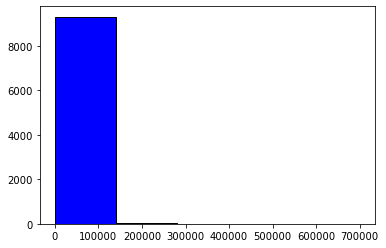

In [240]:
data_sample_df = pd.DataFrame(data_sample, columns = ['Hopital', 'Ville', 'Etat', 'NomMesure', 'IDMesure', 'Comparaison', 'Score'])
import matplotlib.pyplot as plt
plt.hist(data_sample_df['Score'], color = 'blue', edgecolor = 'black', bins = 5)

## OPERATIONS SUR DES DATAFRAMES

## Afficher les elements de base sur le Dataframe - Transformer le Dataframe en RDD

In [242]:
data.printSchema()

root
 |-- Hopital: string (nullable = true)
 |-- Ville: string (nullable = true)
 |-- Etat: string (nullable = true)
 |-- NomMesure: string (nullable = true)
 |-- IDMesure: string (nullable = true)
 |-- Comparaison: string (nullable = true)
 |-- Score: decimal(10,0) (nullable = true)



In [245]:
data.show(5, truncate = True)

+--------------------+------+----+--------------------+---------------+--------------------+-----+
|             Hopital| Ville|Etat|           NomMesure|       IDMesure|         Comparaison|Score|
+--------------------+------+----+--------------------+---------------+--------------------+-----+
|SOUTHEAST ALABAMA...|DOTHAN|  AL|CLABSI: Lower Con...| HAI_1_CI_LOWER|No Different than...|    0|
|SOUTHEAST ALABAMA...|DOTHAN|  AL|CLABSI: Upper Con...| HAI_1_CI_UPPER|No Different than...|    3|
|SOUTHEAST ALABAMA...|DOTHAN|  AL|CLABSI: Number of...|HAI_1_DOPC_DAYS|No Different than...| 1887|
|SOUTHEAST ALABAMA...|DOTHAN|  AL|CLABSI: Predicted...|HAI_1_ELIGCASES|No Different than...|    2|
|SOUTHEAST ALABAMA...|DOTHAN|  AL|CLABSI: Observed ...|HAI_1_NUMERATOR|No Different than...|    3|
+--------------------+------+----+--------------------+---------------+--------------------+-----+
only showing top 5 rows



In [247]:
len(data.columns), data.columns

(7,
 ['Hopital', 'Ville', 'Etat', 'NomMesure', 'IDMesure', 'Comparaison', 'Score'])

In [248]:
data_RDD = data.rdd

## Réaliser des opérations de base sur le Dataframe

Les valeurs moyennes et medianes de la variable 'Score'

In [278]:
median = data.approxQuantile('Score', [0.5], 0)
print(median)
# Median de la variable 'Score' est 2

[2.0]


In [279]:
data.groupBy().mean('Score').collect()
# Moyenne de la variable 'Score' est 3427.2101

[Row(avg(Score)=Decimal('3427.2101'))]

Afficher un dataframe avec le nombre de cas (i.e. lignes) et des statistiques sur la variable 'Score' (moyenne, mediane et variance), agrege/groupe par Etat

In [284]:
row_count = int(data.count())

In [336]:
data_group_etat1 = data.groupby('Etat').agg(psf.avg('Score').alias('mean_Score'))
data_group_etat2 = data.groupby('Etat').count().alias('num_lignes')
data_group_etat3 = data.groupby('Etat').agg(psf.round(psf.var_samp("Score"), 2).alias("var_Score"))
data_group_etat = data_group_etat1.join(data_group_etat2, ["Etat"]).join(data_group_etat3, ["Etat"]).sort("var_Score", ascending = False).show()

+----+----------+-----+--------------+
|Etat|mean_Score|count|     var_Score|
+----+----------+-----+--------------+
|  NY| 5039.0567| 5196|8.2419061144E8|
|  DE| 4188.8347|  246|6.6726447907E8|
|  CT| 3902.8318| 1032|5.3084718839E8|
|  NC| 3862.2798| 2682|5.1321461185E8|
|  FL| 4075.2783| 6402|5.0516379757E8|
|  MN| 4162.6497| 1098|4.9651692864E8|
|  DC| 4428.1905|  300|4.9385943993E8|
|  MI| 4035.6675| 2748|4.6981670905E8|
|  MA| 4114.8655| 1896|4.6311006861E8|
|  TN| 3463.6784| 2436|3.9533875955E8|
|  AL| 3518.1325| 1836|3.8323929738E8|
|  TX| 3460.3408| 7338|3.7286695094E8|
|  NJ| 3855.6052| 2598|3.6440539928E8|
|  KY| 3199.6339| 1692|3.5816418932E8|
|  MD| 3737.1875| 1578|3.5651978132E8|
|  PA| 3540.2833| 4566|3.4527108208E8|
|  NV| 3989.2465|  726| 3.353707722E8|
|  OH| 3397.0894| 4044|3.3509520516E8|
|  MO| 3405.5443| 2130|3.3342069338E8|
|  SC| 3456.4970| 1530|3.3029810226E8|
+----+----------+-----+--------------+
only showing top 20 rows



L'Etat a la plus grande dispersion des valeurs de 'Score'

In [337]:
# C'est NY avec la variance de 8.241

## Realiser des jointures entre plusieurs Dataframes

Creer un nouveau Dataframe contenant uniquement les 5 Etats ayant le plus de cas (i.e. de lignes dans le Dataframe)

In [365]:
data_group_etat_A = data.groupby('Etat').count().sort("count", ascending = False)

Creer un nouveau Dataframe contenant uniquement les valeurs de 'Score' superieures a la mediane

In [377]:
data_group_etat_B = data.filter(data["Score"] > median[0]).select("Etat", "Score")

Joindre ces 2 Dataframes et enlever les colonnes faisant doublon

In [381]:
data_group_etat_final = data_group_etat_A.join(data_group_etat_B, ["Etat"])

La taille du Dataframe obtenu par la jointure?

In [385]:
data_group_etat_final.count()
# Nombre de lignes: 40192

40192

In [391]:
len(data_group_etat_final.columns)
# Nombre de colonnes: 3

3

## REQUETES AVEC SPARK SQL

## Realiser des operations de base sur le Dataframe

Les valeurs moyennes et medianes de la variable 'Score'

In [398]:
data.registerTempTable("data_sql")
spark.sql("SELECT AVG(Score) mean_Score, PERCENTILE_APPROX(Score, 0.5) median_Score \
          FROM data_sql").show()
# la moyenne de Score: 3427.2101
# Le median de Score: 2

+----------+------------+
|mean_Score|median_Score|
+----------+------------+
| 3427.2101|         2.0|
+----------+------------+



Afficher le resultat d'une requete SQL retournant avec le nombre de cas (i.e. lignes) et des statistiques sur la variable 'Score' (moyenne, mediane et variance), agrege/groupe par Etat, par ordre alphabetique croissant des Etats

In [400]:
spark.sql("SELECT Etat, COUNT(Etat) num_cas, AVG(Score) mean_Score, PERCENTILE_APPROX(Score, 0.5) median_Score, VAR_SAMP(Score) variance_Score \
           FROM data_sql \
           GROUP BY Etat \
           ORDER BY Etat ASC").show()

+----+-------+----------+------------+--------------------+
|Etat|num_cas|mean_Score|median_Score|      variance_Score|
+----+-------+----------+------------+--------------------+
|  AK|    216| 2010.6394|           2| 9.812803482104693E7|
|  AL|   1836| 3518.1325|           2|  3.83239297376813E8|
|  AR|   1122| 2762.0305|           2|1.7959849295281547E8|
|  AZ|   1884| 3323.9032|           2| 2.734631132537582E8|
|  CA|  10260| 3004.2803|           2|2.1112096654211372E8|
|  CO|   1338| 2871.3696|           2|1.8651604669340706E8|
|  CT|   1032| 3902.8318|           2|5.3084718839052814E8|
|  DC|    300| 4428.1905|           2|4.9385943992946535E8|
|  DE|    246| 4188.8347|           2| 6.672644790747026E8|
|  FL|   6402| 4075.2783|           2|5.0516379756887835E8|
|  GA|   2976| 3254.4164|           2| 2.800779913481029E8|
|  GU|     18|  293.8824|           2|   543844.1102941177|
|  HI|    402| 2844.9691|           2| 2.147487092031753E8|
|  IA|    966| 2804.4252|           2| 2

L'Etat a la plus grande dispersion des valeurs de 'Score'

In [402]:
spark.sql("SELECT Etat, COUNT(Etat) num_cas, AVG(Score) mean_Score, PERCENTILE_APPROX(Score, 0.5) median_Score, VAR_SAMP(Score) variance_Score \
           FROM data_sql \
           GROUP BY Etat \
           ORDER BY variance_Score DESC").show()

# C'est NY avec variance de 8.24

+----+-------+----------+------------+--------------------+
|Etat|num_cas|mean_Score|median_Score|      variance_Score|
+----+-------+----------+------------+--------------------+
|  NY|   5196| 5039.0567|           2| 8.241906114434166E8|
|  DE|    246| 4188.8347|           2| 6.672644790747026E8|
|  CT|   1032| 3902.8318|           2|5.3084718839052814E8|
|  NC|   2682| 3862.2798|           2| 5.132146118547927E8|
|  FL|   6402| 4075.2783|           2|5.0516379756887835E8|
|  MN|   1098| 4162.6497|           2| 4.965169286387325E8|
|  DC|    300| 4428.1905|           2|4.9385943992946535E8|
|  MI|   2748| 4035.6675|           2| 4.698167090506595E8|
|  MA|   1896| 4114.8655|           2|4.6311006860958654E8|
|  TN|   2436| 3463.6784|           2|3.9533875954558563E8|
|  AL|   1836| 3518.1325|           2|  3.83239297376813E8|
|  TX|   7338| 3460.3408|           2| 3.728669509414615E8|
|  NJ|   2598| 3855.6052|           2|3.6440539928009856E8|
|  KY|   1692| 3199.6339|           2|3.

## Realiser des jointures avec une requete SQL

Creer un nouveau Dataframe contenant uniquement les 5 Etats ayant le plus de cas (i.e. de lignes dans le Dataframe)

In [404]:
data_sql_1 = spark.sql("SELECT Etat, COUNT(Etat) num_cas \
          FROM data_sql \
          GROUP BY Etat \
          ORDER BY num_cas DESC \
          LIMIT 5")

+----+-------+
|Etat|num_cas|
+----+-------+
|  CA|  10260|
|  TX|   7338|
|  FL|   6402|
|  NY|   5196|
|  PA|   4566|
+----+-------+



Creer un nouveau Dataframe contenant uniquement les valeurs de 'Score' superieures a la mediane

In [408]:
data_sql_2 = spark.sql("SELECT Etat, Score \
                       FROM data_sql \
                       WHERE Score > (SELECT PERCENTILE_APPROX(Score, 0.5) FROM data_sql)"
)

Joindre ces 2 Dataframes et enlever les colonnes faisant doublon

In [412]:
data_sql_1.registerTempTable("data_sql_1")
data_sql_2.registerTempTable("data_sql_2")
data_sql_final = spark.sql("SELECT * \
                  FROM data_sql_1 INNER JOIN data_sql_2 ON data_sql_1.Etat = data_sql_2.Etat")
data_sql_final.show()

+----+-------+----+-----+
|Etat|num_cas|Etat|Score|
+----+-------+----+-----+
|  CA|  10260|  CA|    4|
|  CA|  10260|  CA| 1051|
|  CA|  10260|  CA|    3|
|  CA|  10260|  CA| 1621|
|  CA|  10260|  CA|    3|
|  CA|  10260|  CA| 1694|
|  CA|  10260|  CA| 2614|
|  CA|  10260|  CA|    3|
|  CA|  10260|  CA|    3|
|  CA|  10260|  CA|    6|
|  CA|  10260|  CA|   32|
|  CA|  10260|  CA|    4|
|  CA|  10260|  CA|30845|
|  CA|  10260|  CA|    3|
|  CA|  10260|  CA|29092|
|  CA|  10260|  CA|   21|
|  CA|  10260|  CA|   43|
|  CA|  10260|  CA|    3|
|  CA|  10260|  CA|  804|
|  CA|  10260|  CA| 1101|
+----+-------+----+-----+
only showing top 20 rows



La taille du Dataframe obtenu par la jointure SQL

In [414]:
len(data_sql_final.columns)
# Nombre de colonnes: 4

4

In [415]:
data_sql_final.count()
# Nombre de lignes: 14329

14329